In [2]:
import netCDF4 as nc

import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from scipy import stats
from sklearn.svm import SVR

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# Preprocessing data

In [3]:
ds = nc.Dataset('data/air.2020.nc')

In [4]:
ds['air']

<class 'netCDF4._netCDF4.Variable'>
float32 air(time, level, lat, lon)
    long_name: daily mean 6-hourly Air Temperature on Pressure Levels
    units: degK
    precision: 2
    least_significant_digit: 1
    GRIB_id: 11
    GRIB_name: TMP
    var_desc: Air temperature
    dataset: NCEP/DOE AMIP-II Reanalysis (Reanalysis-2) Daily Averages
    level_desc: Pressure Levels
    statistic: Mean
    parent_stat: Individual Obs
    standard_name: air_temperature
    missing_value: -9.96921e+36
    valid_range: [137.5 362.5]
    actual_range: [185.575   315.09998]
unlimited dimensions: time
current shape = (305, 17, 73, 144)
filling on, default _FillValue of 9.969209968386869e+36 used

In [5]:
def get_noaa_lat_lng(coords):
    knn_labels = np.load('knn_labels.npy', allow_pickle=True).item()
    coord_idx = knn_labels.kneighbors(np.array([coords[1], coords[0]]).reshape(1, -1), return_distance=False)[0, 0]
    ## NOAA latitude goes from North To South
    X_noaa_lng = np.linspace(0, 360 -2.5, 144)
    Y_noaa_lat = np.linspace(90, -90, 73)

    lat = None
    lng = None
    y_idx = 0
    idx = 0
    for y in Y_noaa_lat:
        y_idx += 1
        x_idx = 0
        for x in X_noaa_lng:
            x_idx += 1
            if (coord_idx == idx):
                lat = y_idx
                lng = x_idx
                break
            idx += 1
        if lat is not None:
            break

    return lat, lng

In [6]:
coords = (10.96854, -74.78132)
lat, lng = get_noaa_lat_lng(coords)

In [7]:
data = ds['air'][0:304, 0, lat, lng].data

stats.describe(data)

DescribeResult(nobs=304, minmax=(298.55, 302.7), mean=300.8488, variance=0.5410295, skewness=-0.3281554877758026, kurtosis=0.05462318913839326)

## Parsing data (2015-2020)

In [8]:
data = []
for year in range(2015, 2021):
    ds = nc.Dataset(f"data/air.{year}.nc")
    limit = ds['air'].shape[0]
    for day, air in enumerate(ds['air'][0:limit, 0, lat, lng].data):
        date = datetime.datetime(year, 1, 1) + datetime.timedelta(day - 1)
        data.append([date, air])

In [9]:
df = pd.DataFrame(data=data, columns=['date', 'air'])
df.drop_duplicates()

#df['date'] = pd.to_datetime(df.date)
#df = df.sort_values(by='date')

df.reset_index(inplace=True)
df.set_index('date', inplace=True)

## Ploting rolling mean

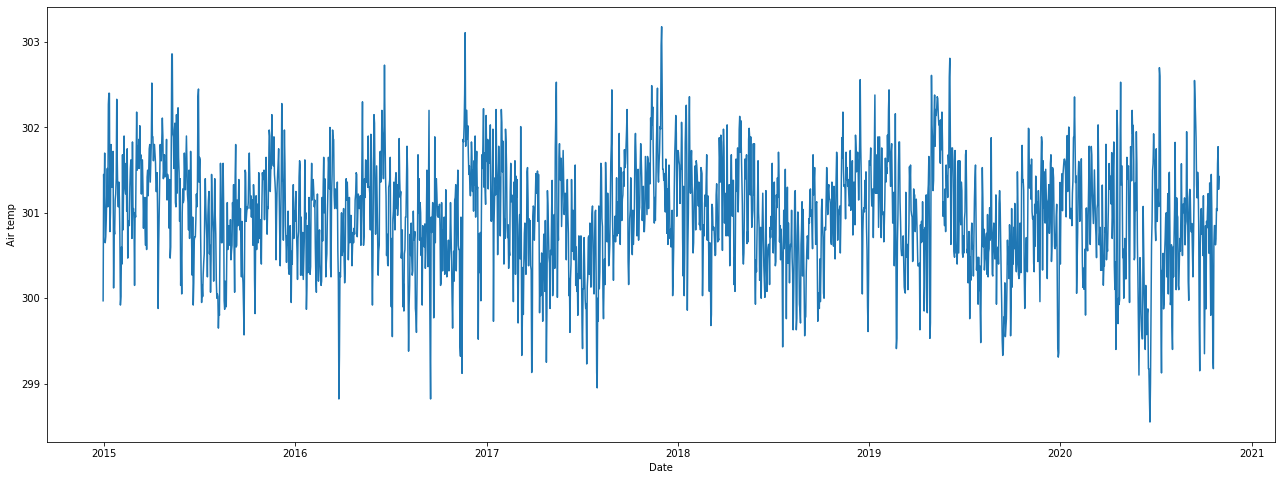

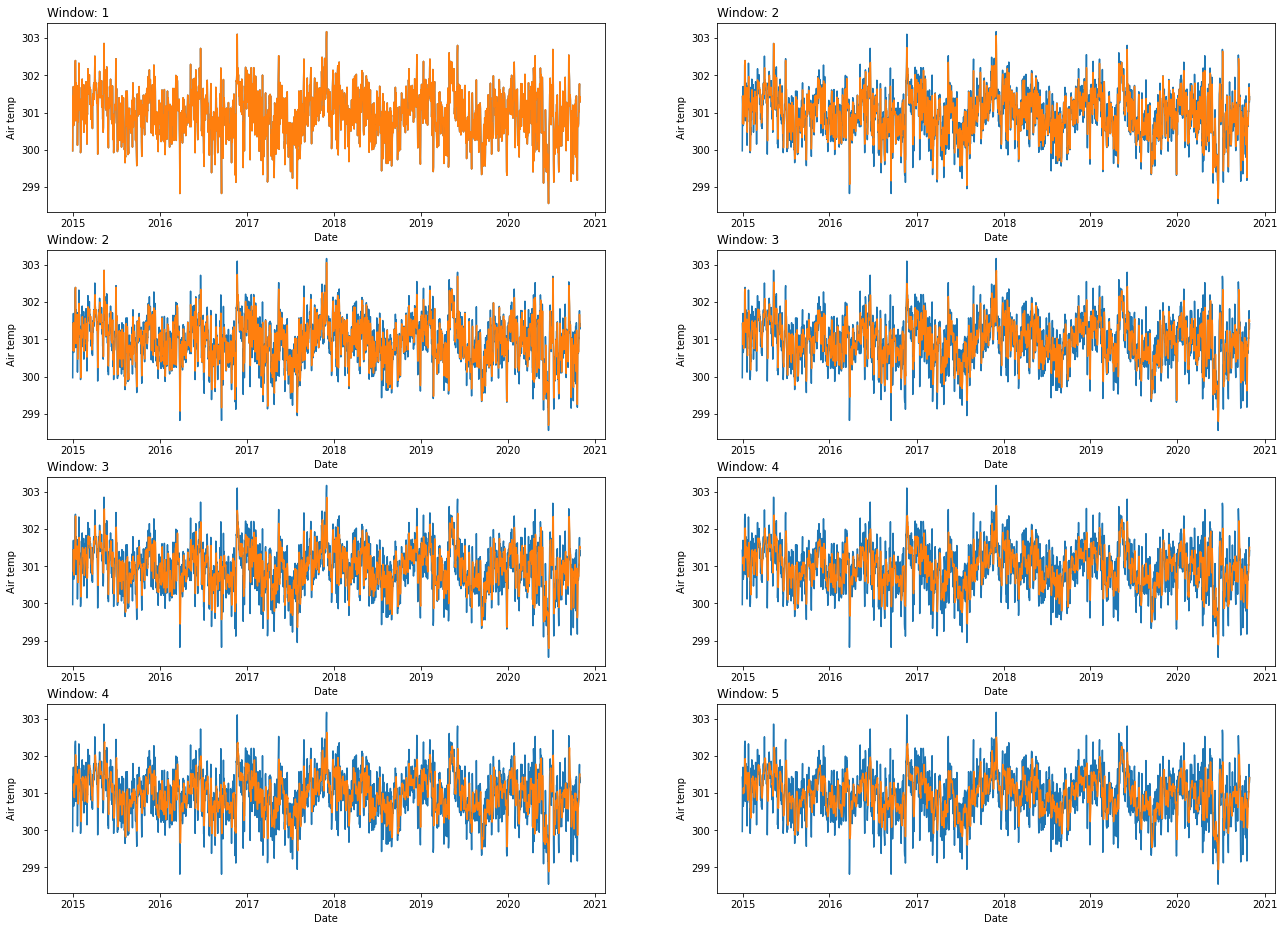

In [93]:
plt.figure(figsize=(22, 8))
plt.plot(df['air'])

plt.xlabel('Date')
plt.ylabel('Air temp')

plt.show()

fig, axs = plt.subplots(4, 2, figsize=(22, 16))

for axs_x in range(0, 4):
    for axs_y in range(0, 2):
        window = axs_x + axs_y + 1
        close_px = df['air']
        mavg = close_px.rolling(window=window).mean()
        
        axs[axs_x, axs_y].set_title(f"Window: {window}", loc='left')

        axs[axs_x, axs_y].plot(close_px, label='Data')
        axs[axs_x, axs_y].plot(mavg, label='mavg')
    
        axs[axs_x, axs_y].set(xlabel='Date', ylabel='Air temp')


## Converting dates

In [11]:
dates_df = df.copy()
dates_df = dates_df.reset_index()

dates_df['date'] = dates_df['date'].map(mdates.date2num)

dates_df.head()

,date,index,air
0,16435.0,0,299.970001
1,16436.0,1,301.450012
2,16437.0,2,301.200012
3,16438.0,3,301.700012
4,16439.0,4,300.649994


## Support Vector Regression

In [41]:
dates = dates_df['date'].values[0: -2].reshape(-1, 1)
air = df['air'].values[0: -2]

svr_rbf.fit(dates, air)

SVR(C=1000.0, gamma=0.1)

In [53]:
last_date = dates_df['date'].values[-1].reshape(-1, 1)
last_air = df['air'].values[-1]

acc = abs(last_air - svr_rbf.predict(last_date)[0])

print(f"Accuracy predicting next value: {acc}")

Accuracy predicting next value: 0.4851888863078102


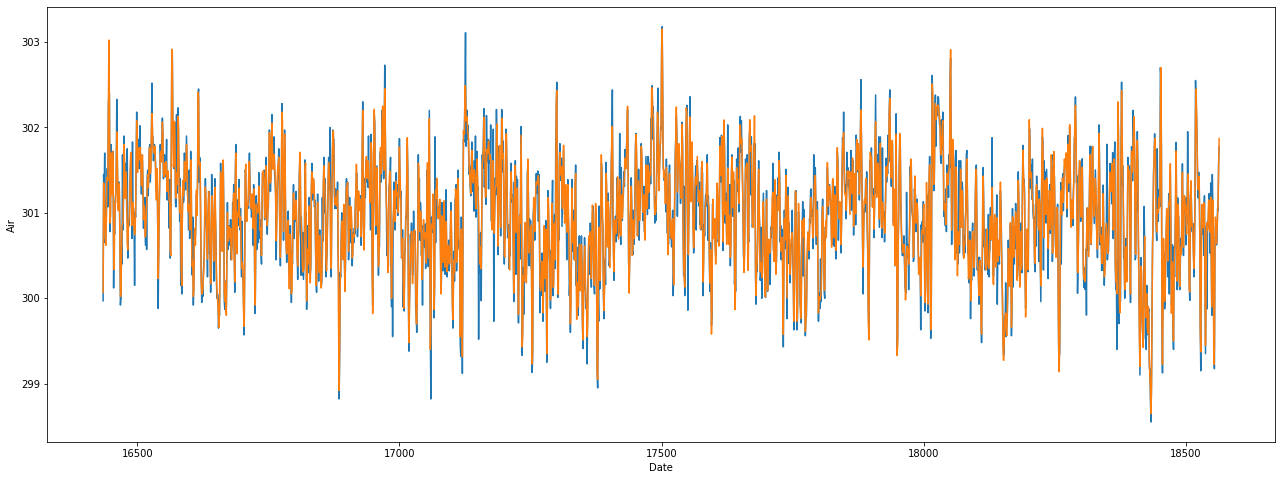

In [66]:
plt.figure(figsize=(22, 8))
plt.plot(dates, air, label='Data')

plt.plot(dates, svr_rbf.predict(dates), label='RBF model') 
plt.xlabel('Date')
plt.ylabel('Air')

plt.show()

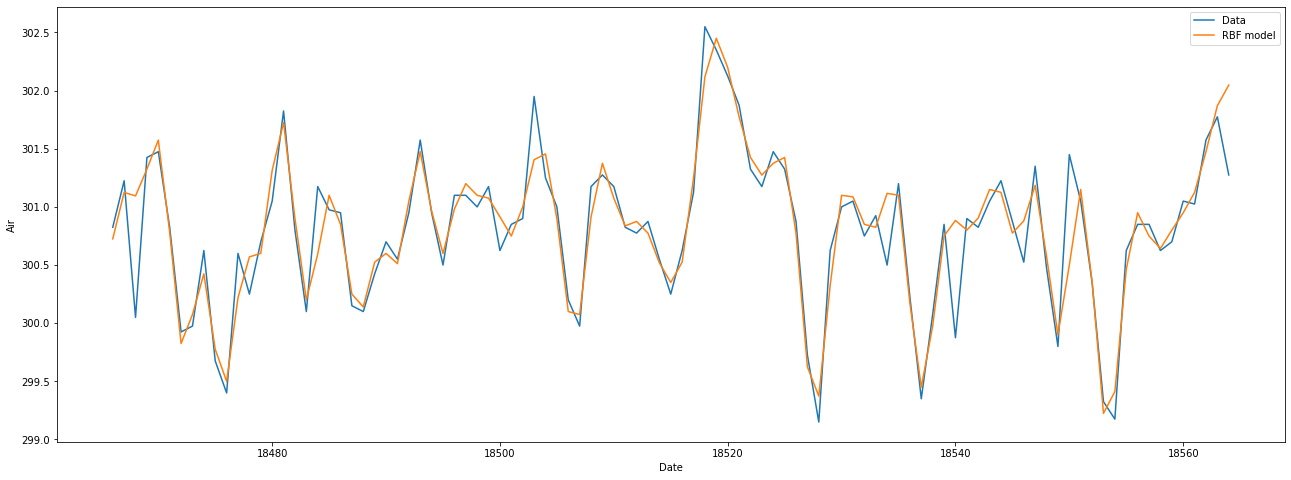

In [63]:
last_dates = dates_df['date'].values[-100:-1].reshape(-1, 1)
last_air_values = df['air'].values[-100:-1]

plt.figure(figsize=(22, 8))
plt.plot(last_dates, last_air_values, label='Data')
plt.plot(last_dates, svr_rbf.predict(last_dates), label='RBF model') 
plt.xlabel('Date')
plt.ylabel('Air')

plt.legend()
plt.show()